In [74]:
#importing my libraries
import pandas as pd
import re
import pickle
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score  # Import cross_val_score



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:

df = pd.read_csv('news.csv',index_col=0)
df.head()



,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [63]:
df.dropna(inplace=True)


In [64]:
df.isnull().sum()


title    0
text     0
label    0
dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 198.0+ KB


Class Distribution:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


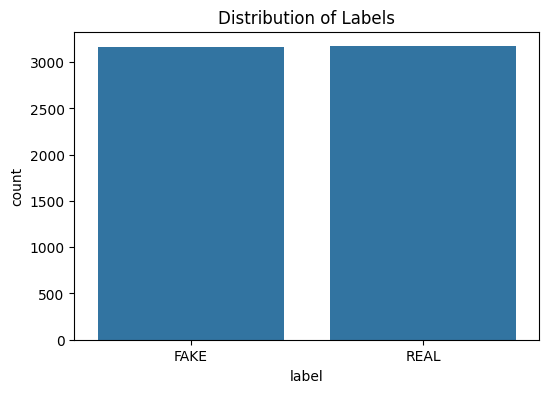

In [66]:
# Exploratory Data Analysis (EDA)
print("Class Distribution:")
print(df['label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.show()

In [67]:
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                          for token in str(sentence).split()
                                          if token not in stopwords.words('english')))
    return preprocessed_text

In [68]:
# Check if preprocessed data exists
try:
    with open('preprocessed_data.pkl', 'rb') as file:
        preprocessed_text = pickle.load(file)
except FileNotFoundError:
    # Preprocessing
    preprocessed_text = preprocess_text(df['text'])

    # Save preprocessed data
    with open('preprocessed_data.pkl', 'wb') as file:
        pickle.dump(preprocessed_text, file)

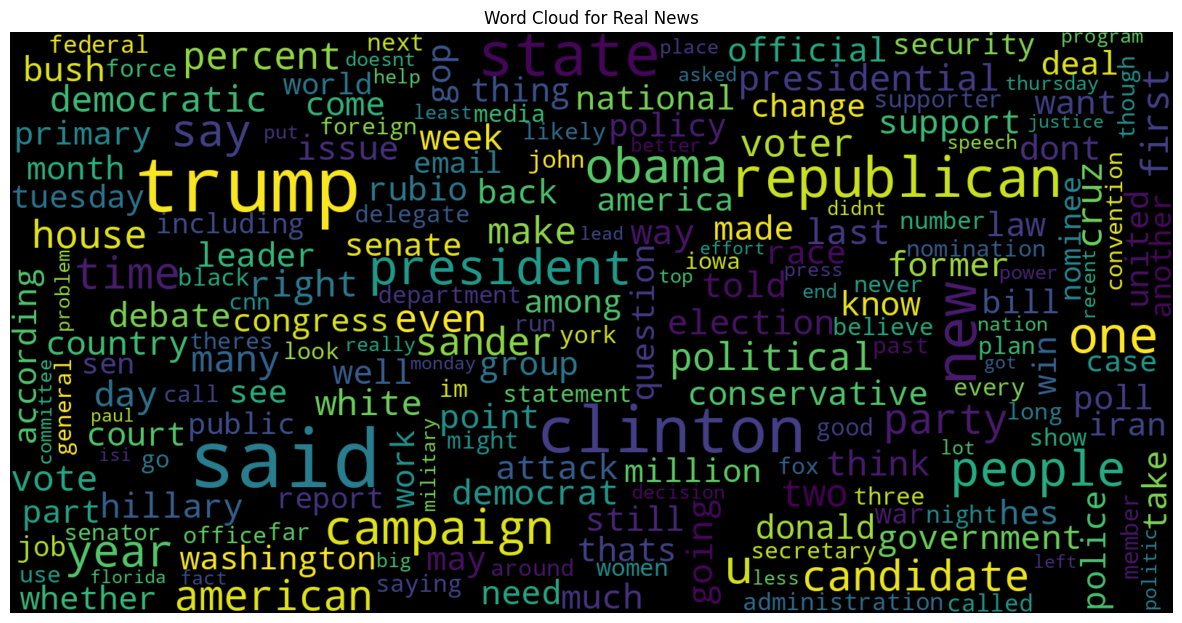

In [69]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Generate word cloud for real news
consolidated_real = ' '.join(preprocessed_text[i] for i in range(len(preprocessed_text)) if y.iloc[i] == 'REAL')
wordCloud_real = WordCloud(width=1600,
                           height=800,
                           random_state=21,
                           max_font_size=110,
                           collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud_real.generate(consolidated_real), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News')
plt.show()

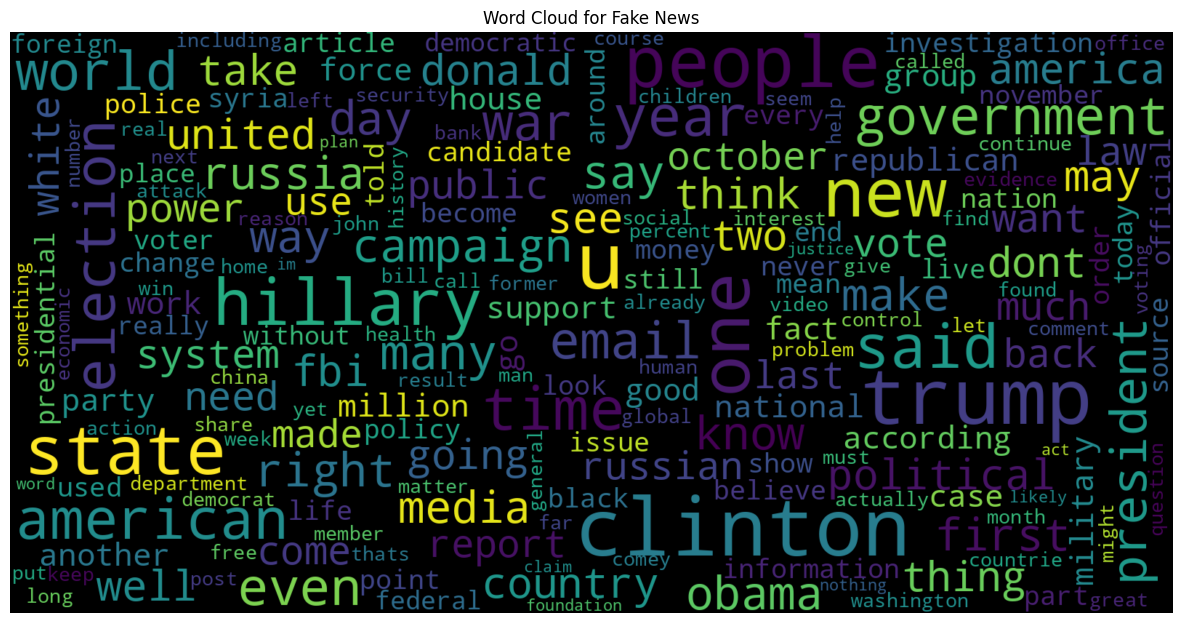

In [50]:
# Generate word cloud for fake news
consolidated_fake = ' '.join(preprocessed_text[i] for i in range(len(preprocessed_text)) if df['label'].iloc[i] == 'FAKE')
wordCloud_fake = WordCloud(width=1600,
                           height=800,
                           random_state=21,
                           max_font_size=110,
                           collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud_fake.generate(consolidated_fake), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')
plt.show()

In [70]:
# Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(preprocessed_text)
y = df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Test multiple algorithms
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB()
}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:")
    print(conf_matrix)
    print("-----------------------------------------")


Training Random Forest...
Random Forest Accuracy: 0.92

Random Forest Classification Report:
              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.92       628
        REAL       0.92      0.93      0.93       639

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267


Random Forest Confusion Matrix:
[[577  51]
 [ 45 594]]
-----------------------------------------
Training SVM...
SVM Accuracy: 0.93

SVM Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       628
        REAL       0.94      0.92      0.93       639

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267


SVM Confusion Matrix:
[[589  39]
 [ 51 588]]
-----------------------------------------
Trai


Misclassified Samples for Naive Bayes:
cedar rapids iowa i one wonderful rallies entire career right 1992 bill clinton said way opening crowd 1100 saturday night two days iowa caucuses cedar rapids tried deliver old feeling wife hillary clinton in crowd one woman held sign said 227 years men its her turn some carried signs books others traveled far missouri they waited hours even fire marshal told room inside high school gymnasium the restive crowd chanted slogans buzzed anticipation finally bill hillary chelsea clinton appeared stage handinhand hour behind schedule as roared hillary clinton beamed it long slog iowa clinton campaign struggled mightily shake label supporters cant muster enthusiasm rivals backers as caucuses near help former president energy level events notably dialing hes charismatic speaker said cigi ross 31 in general id say hes bigger draw people monday night put campaigns months work test can campaigns organization bring supporters can candidate energize voters cl

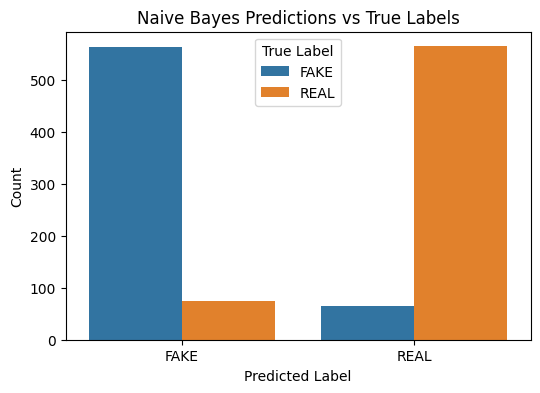

In [72]:
 # Error Analysis
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]
misclassified_samples = [preprocessed_text[i] for i in misclassified_indices]
print(f"\nMisclassified Samples for {name}:")
for sample in misclassified_samples[:5]:
  print(sample)
# Model Comparison
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred, hue=y_test)
plt.title(f'{name} Predictions vs True Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.legend(title='True Label')
plt.show()

In [75]:

# Model Interpretability (SHAP values)
if name == "Random Forest":  # SHAP values currently only supported for tree-based models
    shap.initjs()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=tfidf_vectorizer.get_feature_names_out(), title=f"SHAP Values for {name}")

# Cross-Validation
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"\n{name} Cross-Validation Scores:")
print(cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print("-----------------------------------------")


Naive Bayes Cross-Validation Scores:
[0.8792423  0.88003157 0.86740331 0.87371744 0.86977111]
Mean CV Score: 0.87
-----------------------------------------
